In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path 

In [2]:
model_zoo_src_path = Path("../model_zoo_src")

seed = 0 
hc = True 
n_iter = 10000

influence_file = list(model_zoo_src_path.glob(f"influence*{n_iter}*{seed}*hc_{hc}.npz"))[0]

influences = np.load(influence_file)

influence_scores = influences["influence_scores"]
IF_candidate_points = influences['candidate_points']
OG_train_points = influences['original_train_points']

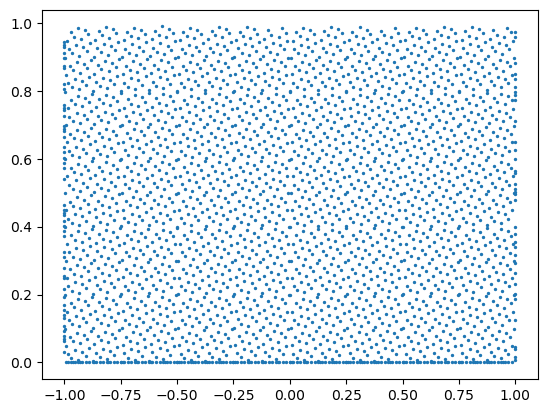

In [3]:
plt.scatter(*OG_train_points.T, s=2)

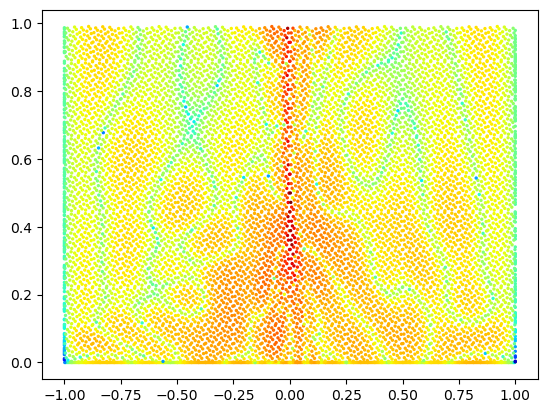

In [4]:
summed_abs_infl_scores = np.abs(influence_scores).sum(axis=0)
plt.scatter(*IF_candidate_points.T, c=np.log(summed_abs_infl_scores), s=2, cmap='jet')

[-0.01835817 -0.01366384 -0.01118133 -0.01030833 -0.00948644 -0.00930505
 -0.00797124 -0.0068591  -0.00654203 -0.0058589  -0.00535324 -0.00524735
 -0.00521406 -0.00508513 -0.00454448 -0.00434267 -0.00403729 -0.00400801
 -0.00359869 -0.00355766 -0.00308137 -0.00303785 -0.0030215  -0.00283078
 -0.00265678 -0.00262366 -0.00222297 -0.00221624 -0.00218399 -0.00216032
 -0.00209183 -0.0020774  -0.00187816 -0.0017965  -0.00167539 -0.00166112
 -0.00165724 -0.00160525 -0.00155804 -0.00151896 -0.00145813 -0.00138092
 -0.00133345 -0.00131697 -0.00128125 -0.00122034 -0.00107522 -0.00104767
 -0.00104592 -0.00104358 -0.00097703 -0.00097065 -0.00095636 -0.00094242
 -0.0009197  -0.00089216 -0.00085447 -0.00084829 -0.00081973 -0.00081812
 -0.00079304 -0.00079245 -0.00079033 -0.00076671 -0.00076008 -0.00075549
 -0.00074441 -0.00074204 -0.00073343 -0.00073217 -0.00072628 -0.00067822
 -0.00067205 -0.00066866 -0.00066013 -0.0006599  -0.00065014 -0.00061169
 -0.00060978 -0.00060822 -0.00060636 -0.00060248 -0

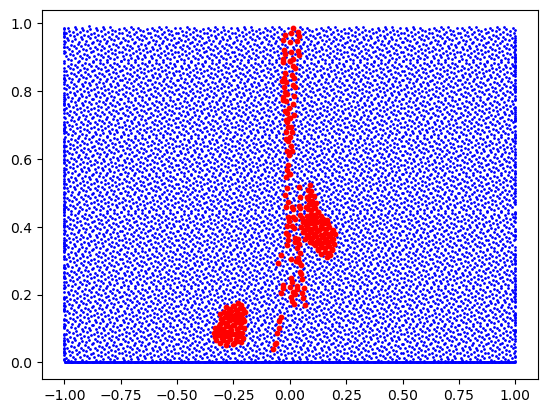

In [ ]:
ratio = 0.10
summed_infl_scores = (-influence_scores).sum(axis=0)
top_idx = np.argsort(summed_infl_scores)[:int(ratio * len(OG_train_points))]
plt.scatter(*IF_candidate_points.T, c='b', s=1)
plt.scatter(*IF_candidate_points[top_idx].T, c='r', s=10)

print(summed_infl_scores[top_idx])

In [6]:
import deepxde as dde 
import torch

hard_constrained = hc 
n_iterations = 10000
layers = [2] + [20] * 3 + [1]
num_domain = 2540
num_boundary = 80
num_initial = 160
n_candidate_points = 10_000
lr = 1e-3

def burgers_equation(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / dde.backend.torch.pi * dy_xx


# define the geometry and time domain
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# define the boundary and initial conditions
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: -dde.backend.torch.sin(
        dde.backend.torch.pi * dde.backend.as_tensor(x[:, 0:1])
    ),
    lambda _, on_initial: on_initial,
)

dde.config.set_random_seed(seed)

net = dde.maps.FNN(layers, "tanh", "Glorot normal")

def reset_data(data, data_points):
    data.train_x_all = data_points["train_x_all"]
    data.train_x = data_points["train_x"]
    data.train_x_bc = data_points["train_x_bc"]
    data.test_x = data_points["test_x"]
    return data

if hard_constrained:

    def output_transform(x, y):
        return -torch.sin(np.pi * x[:, 0:1]) + (1 - x[:, 0:1] ** 2) * (x[:, 1:]) * y

    net.apply_output_transform(output_transform)
    ic_bcs = []

    model_name_src = f"../model_zoo_src/adam_{n_iterations}_best_seed_{seed}_hardconstrained.pt"
else:
    ic_bcs = [bc, ic]

    model_name_src = f"../model_zoo_src/adam_{n_iterations}_best_seed_{seed}.pt"

net.load_state_dict(torch.load(model_name_src)["model_state_dict"])

data = dde.data.TimePDE(
    geomtime,
    burgers_equation,
    ic_bcs=ic_bcs,
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_initial=num_initial,
    num_test=10_000,
)

data_points = np.load(
    f"../model_zoo_src/data_{num_domain}_{num_boundary}_{num_initial}_{seed}.npz"
)
reset_data(data, data_points)

model = dde.Model(data, net)
model.compile("adam", lr=lr)



Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.380652 s



In [7]:
def gen_testdata():
    data = np.load("../dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

Text(0.5, 1.0, 'Residual')

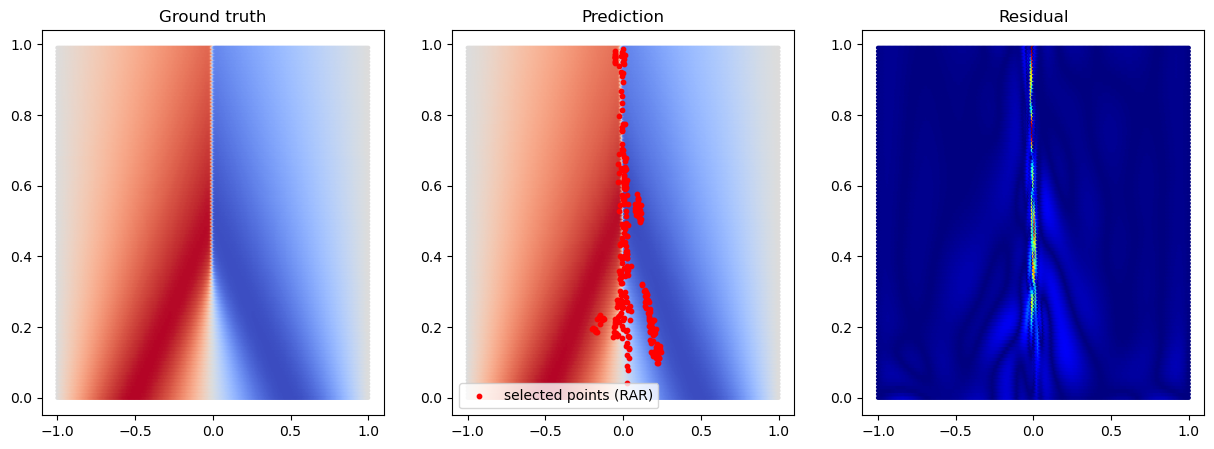

In [8]:
candidate_points = geomtime.random_points(n_candidate_points)
residual = np.abs(
    model.predict(candidate_points, operator=burgers_equation)
)[:, 0]
err_eq = torch.tensor(residual)
topk_idx = torch.topk(err_eq, int(ratio * len(data.train_x_all)), dim=0)[
    1
].numpy()

X, Y = gen_testdata()
fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))

ax[0].scatter(*X.T, c = Y.flatten(), s = 4, cmap='coolwarm')
ax[0].set_title("Ground truth")
ax[1].scatter(*X.T, c = model.predict(X)[:, 0], s = 4, cmap='coolwarm')
ax[1].scatter(*candidate_points[topk_idx].T, c = 'r', s = 10, label='selected points (RAR)')
ax[1].set_title("Prediction")
ax[1].legend()
ax[2].scatter(*X.T, c = np.abs(model.predict(X, operator=burgers_equation)[:, 0]), s = 4, cmap='jet')
ax[2].set_title("Residual")

In [9]:
np.concatenate([np.arange(0,0.11, 0.01), np.arange(0.2, 1.1, 0.1)])

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  ])

Text(0.5, 1.0, 'IF (log(abs))')

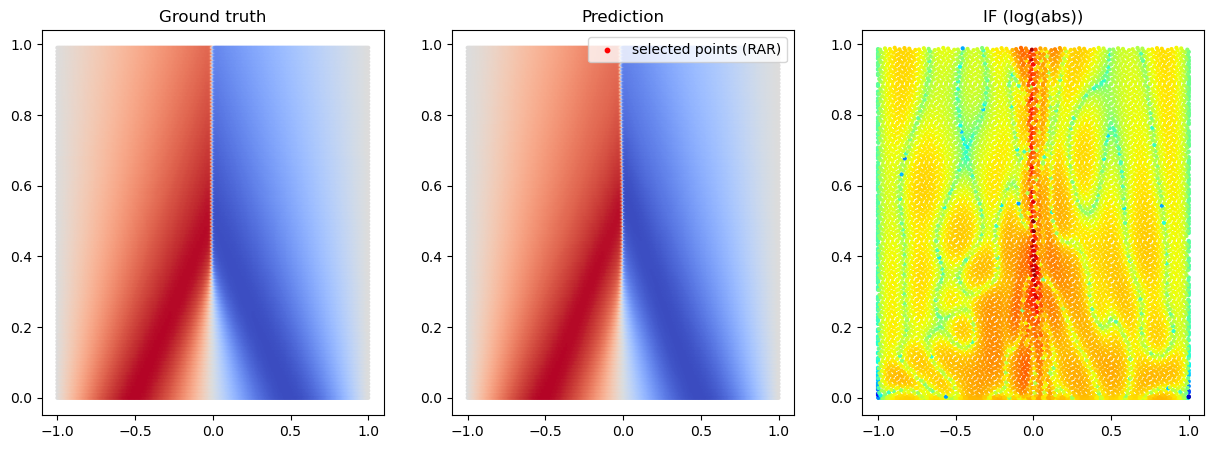

In [10]:
summed_abs_infl_scores = np.abs(influence_scores).sum(axis=0)
ratio=0
topk_idx = torch.topk(torch.tensor(summed_abs_infl_scores), int(ratio * len(OG_train_points)), dim=0)[1].numpy()

X, Y = gen_testdata()
fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))

ax[0].scatter(*X.T, c = Y.flatten(), s = 4, cmap='coolwarm')
ax[0].set_title("Ground truth")
ax[1].scatter(*X.T, c = model.predict(X)[:, 0], s = 4, cmap='coolwarm')
ax[1].scatter(*IF_candidate_points[topk_idx].T, c = 'r', s = 10, label='selected points (RAR)')
ax[1].set_title("Prediction")
ax[1].legend()
ax[2].scatter(*IF_candidate_points.T, c = np.log(summed_abs_infl_scores) , s = 4, cmap='jet')
ax[2].set_title("IF (log(abs))")


Text(0.5, 1.0, 'IF')

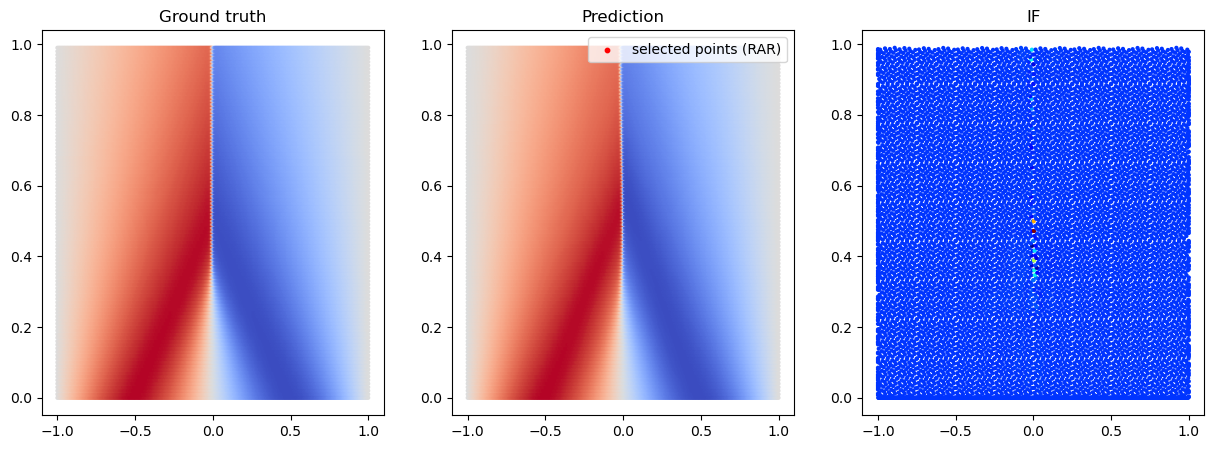

In [11]:
summed_abs_infl_scores = (-influence_scores).sum(axis=0)
topk_idx = torch.topk(torch.tensor(summed_abs_infl_scores), int(ratio * len(OG_train_points)), dim=0)[1].numpy()

X, Y = gen_testdata()
fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))

ax[0].scatter(*X.T, c = Y.flatten(), s = 4, cmap='coolwarm')
ax[0].set_title("Ground truth")
ax[1].scatter(*X.T, c = model.predict(X)[:, 0], s = 4, cmap='coolwarm')
ax[1].scatter(*IF_candidate_points[topk_idx].T, c = 'r', s = 10, label='selected points (RAR)')
ax[1].set_title("Prediction")
ax[1].legend()
ax[2].scatter(*IF_candidate_points.T, c = summed_abs_infl_scores , s = 4, cmap='jet')
ax[2].set_title("IF")


In [15]:
influence_scores.shape

(2780, 9998)

In [17]:
IF_candidate_points.shape

(9998, 2)

Text(0.5, 1.0, 'IF')

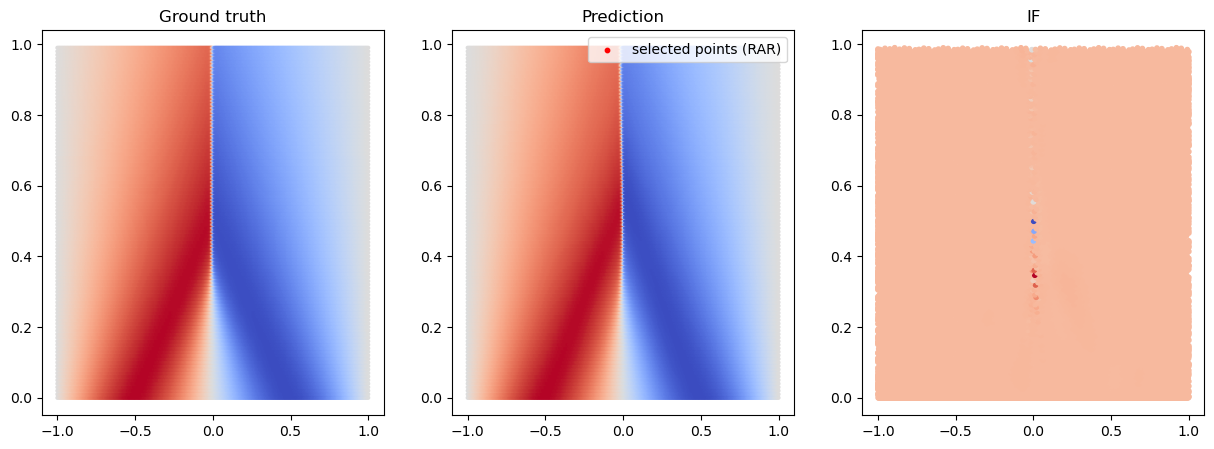

In [27]:
summed_abs_infl_scores = np.abs(influence_scores).sum(axis=0)
topk_idx = torch.topk(torch.tensor(summed_abs_infl_scores), int(ratio * len(OG_train_points)), dim=0)[1].numpy()

X, Y = gen_testdata()
fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))

ax[0].scatter(*X.T, c = Y.flatten(), s = 4, cmap='coolwarm')
ax[0].set_title("Ground truth")
ax[1].scatter(*X.T, c = model.predict(X)[:, 0], s = 4, cmap='coolwarm')
ax[1].scatter(*IF_candidate_points[topk_idx].T, c = 'r', s = 10, label='selected points (RAR)')
ax[1].set_title("Prediction")
ax[1].legend()
ax[2].scatter(*IF_candidate_points.T, c = influence_scores[1000,:] , s = 10, cmap='coolwarm')
ax[2].set_title("IF")


In [12]:
geom.random_points(0)

array([], shape=(0, 1), dtype=float32)